In [ ]:
import os
import re
import pandas as pd
import tensorflow as tf
from tensorflow.keras import utils
data_set = tf.keras.utils.get_file(
    fname="imdb.tar.gz", #download file name
    origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
    extract = True )

84140032/84125825 [==============================] - 18s 0us/step


In [ ]:
data_set

'/root/.keras/datasets/imdb.tar.gz'

In [ ]:
def directory_data(directory):
  data = {}
  data["review"] = []
  for file_path in os.listdir(directory):
    with open(os.path.join(directory, file_path), "r", encoding='utf-8') as file:
      data["review"].append(file.read())
  return pd.DataFrame.from_dict(data)

In [ ]:
def data(directory):
  pos_df = directory_data(os.path.join(directory, "pos"))
  neg_df = directory_data(os.path.join(directory, "neg"))
  pos_df["sentiment"] = 1
  neg_df["sentiment"] = 0
  return pd.concat([pos_df, neg_df])

In [ ]:
train_df = data(os.path.join(os.path.dirname(data_set), "aclImdb", "train"))
test_df = data(os.path.join(os.path.dirname(data_set), "aclImdb", "test"))

In [ ]:
train_df.head()

,review,sentiment
0,I admit not being that fond of Oliver! as a yo...,1
1,"""Twelve monkeys""'s got all the elements to bec...",1
2,"Although written by Stephen King, an overrated...",1
3,Interesting how much more realistic Brosnan's ...,1
4,"This is indeed a funny show, done in a creepy ...",1


In [ ]:
reviews = list(train_df['review'])

In [ ]:
tokenized_reviews = [r.split() for r in reviews]
review_len_by_token = [len(t) for t in tokenized_reviews]
review_len_by_alphabet = [len(s.replace(' ', '')) for s in reviews]

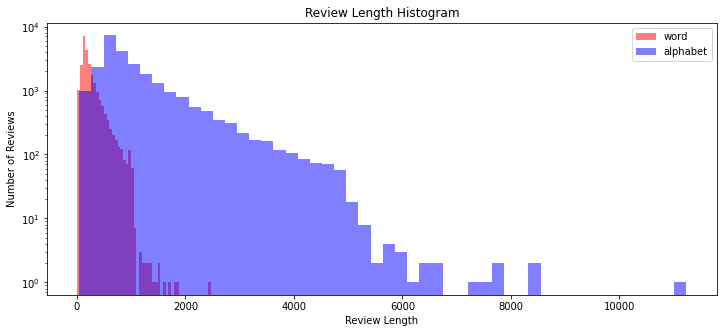

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.hist(review_len_by_token, bins=50, alpha=0.5, color='r', label='word')
plt.hist(review_len_by_alphabet, bins=50, alpha=0.5, color='b', label='alphabet')
plt.yscale('log', nonposy='clip')

plt.title('Review Length Histogram')
plt.xlabel('Review Length')
plt.ylabel('Number of Reviews')
plt.legend()
plt.show()

In [ ]:
import numpy as np
print('문장 최대 길이: ', np.max(review_len_by_token))
print('문장 최소 길이: ', np.min(review_len_by_token))
print('문장 평균 길이: ', np.mean(review_len_by_token))
print('문장 길이 표준편차: ', np.std(review_len_by_token))
print('문장 중간 길이: ', np.median(review_len_by_token))
print('제 1 사분위 길이: ', np.percentile(review_len_by_token, 25))
print('제 3 사분위 길이: ', np.percentile(review_len_by_token, 75))

문장 최대 길이:  2470
문장 최소 길이:  10
문장 평균 길이:  233.7872
문장 길이 표준편차:  173.72955740506563
문장 중간 길이:  174.0
제 1 사분위 길이:  127.0
제 3 사분위 길이:  284.0


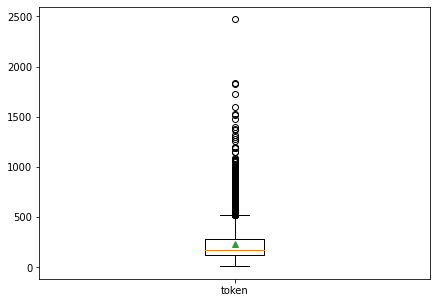

In [ ]:
plt.figure(figsize=(7, 5))
plt.boxplot([review_len_by_token], labels = ['token'], showmeans=True)
plt.show()

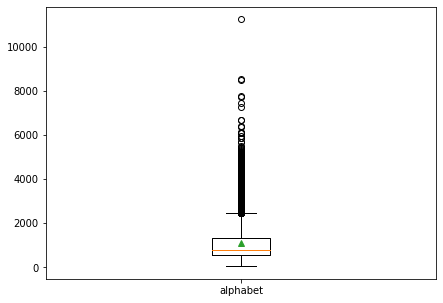

In [ ]:
plt.figure(figsize=(7, 5))
plt.boxplot([review_len_by_alphabet], labels = ['alphabet'], showmeans=True)
plt.show()

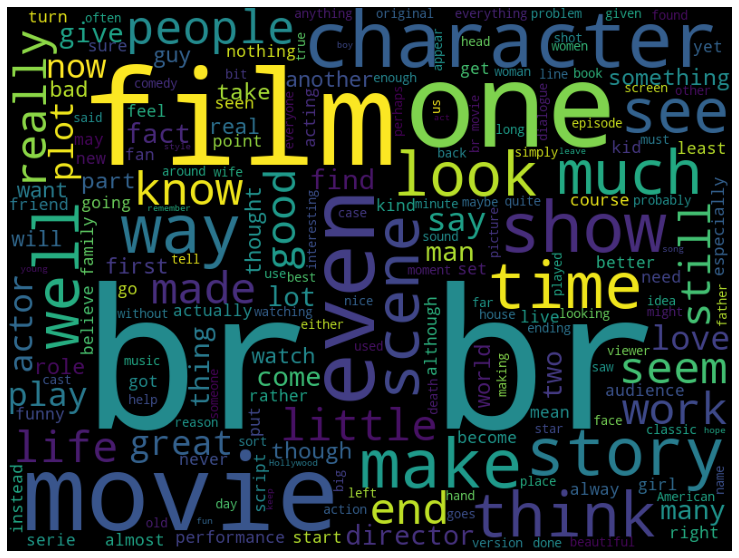

In [ ]:
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', width=800, height=600).generate(' '.join(train_df['review']))

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

1    12500
0    12500
Name: sentiment, dtype: int64


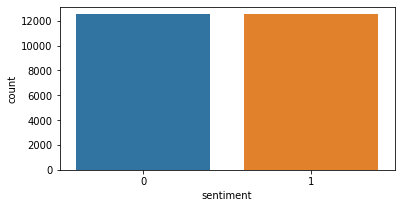

In [ ]:
import seaborn as sns

sentiment = train_df['sentiment'].value_counts()
print(sentiment)
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(6, 3)
sns.countplot(x=train_df['sentiment'])
plt.show()

In [15]:
import os
current_path = os.getcwd()
print(current_path)
from google.colab import drive
drive.mount('/content/drive')

/content
Mounted at /content/drive


In [16]:
import zipfile
DATA_IN_PATH = '/content/drive/MyDrive/DeepLearning_NLP/data_in/'
file_list = ['labeledTrainData.tsv.zip', 'unlabeledTrainData.tsv.zip', 'testData.tsv.zip']

for file in file_list:
  zipRef = zipfile.ZipFile(DATA_IN_PATH + file, 'r')
  zipRef.extractall(DATA_IN_PATH)
  zipRef.close()

In [22]:
import os

print("File Size: ")
for file in os.listdir(DATA_IN_PATH):
  if 'tsv' in file and 'zip' not in file:
    print(file.ljust(30), str(round(os.path.getsize(DATA_IN_PATH + file)/ 1000000, 2)) + 'MB')

train_data = pd.read_csv(DATA_IN_PATH + 'labeledTrainData.tsv', header = 0, delimiter = '\t', quoting = 3)
print('\n', train_data.head(), '\n')
print('The number of entire traigning data: {}'.format(len(train_data)))
train_length = train_data['review'].apply(len)
train_length.head()

File Size: 
labeledTrainData.tsv           33.56MB
unlabeledTrainData.tsv         67.28MB
testData.tsv                   32.72MB

          id  sentiment                                             review
0  "5814_8"          1  "With all this stuff going down at the moment ...
1  "2381_9"          1  "\"The Classic War of the Worlds\" by Timothy ...
2  "7759_3"          0  "The film starts with a manager (Nicholas Bell...
3  "3630_4"          0  "It must be assumed that those who praised thi...
4  "9495_8"          1  "Superbly trashy and wondrously unpretentious ... 

The number of entire traigning data: 25000


0    2304
1     948
2    2451
3    2247
4    2233
Name: review, dtype: int64

In [32]:
import re
import json
import pandas as pd
import numpy as np
# import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

DATA_IN_PATH = '/content/drive/MyDrive/DeepLearning_NLP/data_in/'
train_data = pd.read_csv(DATA_IN_PATH + 'labeledTrainData.tsv', header=0, delimiter = '\t', quoting = 3)

In [33]:
review = train_data['review'][0]
review_text = BeautifulSoup(review, "html5lib").get_text()
review_text = re.sub("[^a-zA-Z]", " ", review_text)
review_text = review_text.lower()
words = review_text.split()
# nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
words = [w for w in words if not w in stop_words]
print(words)
clean_review = ' '.join(words)
print(clean_review)

['stuff', 'going', 'moment', 'mj', 'started', 'listening', 'music', 'watching', 'odd', 'documentary', 'watched', 'wiz', 'watched', 'moonwalker', 'maybe', 'want', 'get', 'certain', 'insight', 'guy', 'thought', 'really', 'cool', 'eighties', 'maybe', 'make', 'mind', 'whether', 'guilty', 'innocent', 'moonwalker', 'part', 'biography', 'part', 'feature', 'film', 'remember', 'going', 'see', 'cinema', 'originally', 'released', 'subtle', 'messages', 'mj', 'feeling', 'towards', 'press', 'also', 'obvious', 'message', 'drugs', 'bad', 'kay', 'visually', 'impressive', 'course', 'michael', 'jackson', 'unless', 'remotely', 'like', 'mj', 'anyway', 'going', 'hate', 'find', 'boring', 'may', 'call', 'mj', 'egotist', 'consenting', 'making', 'movie', 'mj', 'fans', 'would', 'say', 'made', 'fans', 'true', 'really', 'nice', 'actual', 'feature', 'film', 'bit', 'finally', 'starts', 'minutes', 'excluding', 'smooth', 'criminal', 'sequence', 'joe', 'pesci', 'convincing', 'psychopathic', 'powerful', 'drug', 'lord', 

In [34]:
def preprocessing(review, remove_stopwords = False):
  review_text = BeautifulSoup(review, "html5lib").get_text()
  review_text = re.sub("[^a-zA-Z]", " ", review_text)
  review_text = review_text.lower()
  if remove_stopwords:
    words = review_text.split()
    stops = set(stopwords.words("english"))
    words = [w for w in words if not w in stops]
    review_text = ' '.join(words)
  return review_text
clean_train_reviews = []
for review in train_data['review']:
  clean_train_reviews.append(preprocessing(review, remove_stopwords = True))
clean_train_df = pd.DataFrame({'review': clean_train_reviews,
                               'sentiment': train_data['sentiment']})

In [37]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_reviews)
text_sequences = tokenizer.texts_to_sequences(clean_train_reviews)

MAX_SEQUENCE_LENGTH = 174 # 임의 세팅, tfidvectorizer를 사용하지 않았을 때
train_inputs = pad_sequences(text_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
print('Train Data: ', train_inputs.shape)

train_labels = np.array(train_data['sentiment'])
print('Label: ', train_labels.shape)

Train Data:  (25000, 174)
Label:  (25000,)


In [36]:
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
reviews = list(train_data['review'])
sentiments = list(train_data['sentiment'])
vectorizer = TfidfVectorizer(min_df = 0.0, analyzer="char", sublinear_tf = True, ngram_range = (1,3), max_features = 5000)
X = vectorizer.fit_transform(reviews)
y = np.array(sentiments)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
lgs = LogisticRegression(class_weight='balanced')
lgs.fit(X_train, y_train) # predicted = lgs.predict(X_test)
print("Accuracy: %f" % lgs.score(X_test, y_test))

(20000, 5000) (5000, 5000) (20000,) (5000,)
Accuracy: 0.869600


In [41]:
from keras.models import Sequential
from keras.layers import Dense
X_train1 = X_train.toarray()
X_test1 = X_test.toarray()

model = Sequential()
model.add(Dense(5000, activation='relu')) # hidden
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
model.fit(X_train1, y_train, epochs=10, verbose=1)

_, accuracy = model.evaluate(X_test1, y_test) # _ 부분은 loss값, 출력하지 않음
print('Accuracy: ', accuracy)
model.summary()

Epoch 1/10
625/625 [==============================] - 242s 384ms/step - loss: 0.3807 - accuracy: 0.8268
Epoch 2/10
625/625 [==============================] - 234s 375ms/step - loss: 0.2790 - accuracy: 0.8839
Epoch 3/10
625/625 [==============================] - 233s 373ms/step - loss: 0.2301 - accuracy: 0.9025
Epoch 4/10
625/625 [==============================] - 239s 382ms/step - loss: 0.1712 - accuracy: 0.9301
Epoch 5/10
625/625 [==============================] - 243s 389ms/step - loss: 0.0865 - accuracy: 0.9720
Epoch 6/10
625/625 [==============================] - 239s 383ms/step - loss: 0.0301 - accuracy: 0.9933
Epoch 7/10
625/625 [==============================] - 235s 376ms/step - loss: 0.0061 - accuracy: 0.9998
Epoch 8/10
625/625 [==============================] - 234s 375ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 9/10
625/625 [==============================] - 270s 432ms/step - loss: 7.2717e-04 - accuracy: 1.0000
Epoch 10/10
157/157 [==============================] - 10s 6